# Leak Location Optimization
### Import Necessary Libraries

In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import pygad
import numpy
import glob
import wntr
import os

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [55]:
# wipe all solutions in the directory
all_solutions = glob.glob('../temp/FITNESS_SOLUTION_*')
all_generations = glob.glob('../temp/GENERATION_*')
# for i in all_solutions:
#     os.remove(i)
# for j in all_generations:
#     os.remove(j)


# Uncomment and run the above code if you want to re-optimze this project otherwise, go ahead.
# Recommendation: Uncomment and run the code if you want re-optimize.

['../temp/FITNESS_SOLUTION_0.12818641705620504.csv',
 '../temp/FITNESS_SOLUTION_1.3998393575096293.csv',
 '../temp/FITNESS_SOLUTION_0.42289344896704684.csv',
 '../temp/FITNESS_SOLUTION_0.5276513652039161.csv',
 '../temp/FITNESS_SOLUTION_1.3490236772261652.csv',
 '../temp/FITNESS_SOLUTION_0.4173560138112884.csv',
 '../temp/FITNESS_SOLUTION_0.2646256494244663.csv',
 '../temp/FITNESS_SOLUTION_0.31484920820215545.csv',
 '../temp/FITNESS_SOLUTION_0.17194962376373946.csv',
 '../temp/FITNESS_SOLUTION_0.6544895696268505.csv']

In [3]:
class Config:
    num_generations =100 #Number of generations.
    num_parents_mating = 1 # Number of solutions to be selected as parents in the mating pool.
    sol_per_pop = 20 # Number of solutions in the population.
    num_genes = 1 #len(function_inputs) --> this can be an array
    init_range_low = 0
    init_range_high = 1
    parent_selection_type = "sss" # Type of parent selection.
    keep_parents = -1 # Number of parents to keep in the next population. -1 means keep all parents and 0 means keep nothing.
    crossover_type = "single_point" # Type of the crossover operator. 
    mutation_type = "random" # Type of the mutation operator.
    mutation_num_genes=1 # Type of the mutation operator.
    last_fitness = 0
    
    INP_FILE_PATH = r"../data/Real_Synthetic_Net.inp" 
    TEMP_DIR = "../temp/"
    PLOTS_DIR = "../plots"
    FUNCTION_INPUTS = None
    DESIRED_OUTPUT = None

In [4]:
class WaterLeakModel(Config):
    
    def __init__(self, node:str):
        ''' 
            node: node/junction ID in the network
        '''
        self.node = node
        
        # Check if node is junction_name 
        wn = wntr.network.WaterNetworkModel(self.INP_FILE_PATH)
        assert wn.junction_name_list.count(node) == 1, "Node not found in the network"
        self.node_index = wn.junction_name_list.index(node)
    
    def simulate(self, wn, plot_graph=True):
        """
        If plot_graph is set to true, a graph of the network is plotted after simulation
        """
        # Plot pressure after add leak to node
            
        sim = wntr.sim.WNTRSimulator(wn)
        results = sim.run_sim()
        pressure = results.node['pressure']
        pressure_at_N6 = pressure.loc[:,wn.junction_name_list[self.node_index]]
        if plot_graph:
            wntr.graphics.plot_network(wn, node_attribute=pressure.any(), node_size=150, title='Pressure at 0 hours')
        
        return results
    
    def change_discharge_coefficient(self, wn, emitter_value):
        """
        This function changes the emitter coefficient for selected node in the network, and create a 
        structured representation of our data, a csv.
        
        parameters
        ----------
        emitter_value: the emitter coefficient value
        """

        node = wn.get_node(str(self.node))
        node.add_leak(wn, area=0.00015, start_time=0, end_time=1, discharge_coeff=emitter_value)
        return self.simulate(wn, plot_graph=False)
    
    def export_results(self, solutions:list, path:str, name:str):
        """
        Concatenates all solutions generated and exports as a single csv file
        
        parameters
        ----------
        solution: a list of all paths to the solutions csv files
        path: path where concatenated solution will be exported to
        name: name to be assigned to exported file
        """
        if not os.path.exists(path):
            os.mkdir(path)
        
        temp = pd.DataFrame()
        for i in range(len(solutions)):
            data = pd.read_csv(solutions[i])
            if i == 0:
                temp = data
            else:
                temp = pd.concat([temp, data])
        name+=".csv"
        try:
            temp.to_csv(os.path.join(path,name),index=False)
            print(f'File Exported Successfully to path: {os.path.join(path, name)}')
        except Exception as e:
            print(e)
        

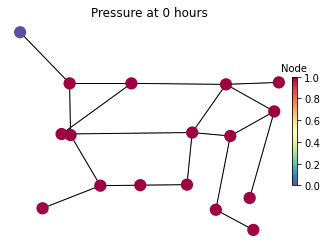

In [5]:
# Instantiate the pygad optimization class
water_model = WaterLeakModel(node='N6')
water_model.num_generations = 100

# Add leak and simulate
wn = wntr.network.WaterNetworkModel(water_model.INP_FILE_PATH)
node = wn.get_node('N6')
node.add_leak(wn, area=0.00015, start_time=0, end_time=1, discharge_coeff=.5)
water_model.simulate(wn, plot_graph=True)

water_model.FUNCTION_INPUTS = 0.5
water_model.DESIRED_OUTPUT = node.head - node.elevation

> **The node with the highest fitness is considered to have a leak.**

In [12]:
water_model = WaterLeakModel(node='N6')
config = Config()

In [51]:
desired_output = 26.5
function_input = 0.5
all_nodes = wn.junction_name_list
data=pd.DataFrame(columns=['NODE','EMITTER_COEFFICIENT','OUTPUT','FITNESS']) 

In [52]:
for i in range(len(all_nodes)):
    wn = wntr.network.WaterNetworkModel(water_model.INP_FILE_PATH)
    water_model = WaterLeakModel(node=wn.junction_name_list[i])
    results = water_model.change_discharge_coefficient(wn, emitter_value=function_input)
    pressure = results.node['pressure']
    output = pressure.loc[:,'N6']
    fitness = 1.0 / (np.abs(output - desired_output) + 0.000001)
    
    data=data.append({'NODE':all_nodes[i],'EMITTER_COEFFICIENT':function_input,'OUTPUT':list(output)[0],'FITNESS':list(fitness)[0]},ignore_index=True)
    data=data.sort_values(by='FITNESS',ascending=False)
    data=data.reset_index(drop=True)

In [53]:
data

,NODE,EMITTER_COEFFICIENT,OUTPUT,FITNESS
0,N6,0.5,26.540357,24.777989
1,N7,0.5,26.545955,21.759754
2,N16,0.5,26.545978,21.748840
3,N13,0.5,26.548399,20.661012
4,N8,0.5,26.554113,18.479601
5,N12,0.5,26.555828,17.911717
6,N9,0.5,26.557455,17.404645
7,N14,0.5,26.557721,17.324433
8,N4,0.5,26.564291,15.553999
9,N3,0.5,26.565786,15.200656


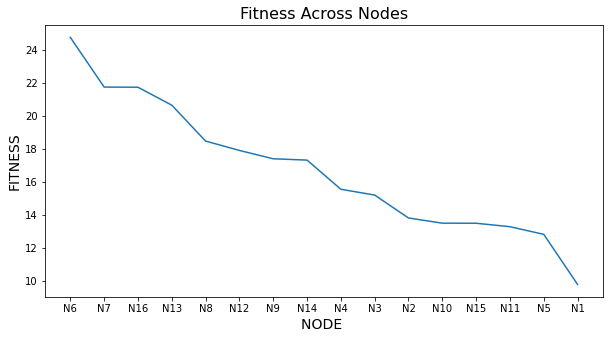

In [54]:
plt.figure(figsize=(10,5))
plt.plot(df['NODE'],df['FITNESS'])

plt.xlabel('NODE ',fontsize=14)
plt.ylabel('FITNESS',fontsize=14)

plt.title('Fitness Across Nodes',fontsize=16)
plt.savefig(f"{water_model.TEMP_DIR}/node_fitness.png")

After our optimization it was proven that the leak node was `NODE 6` since node 6 has the highest fitness